### Importing the Libraries

In [45]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd 

import glob, string

from tqdm import tqdm
from PIL import Image

from torchinfo import summary

import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms
from torch.utils.data import DataLoader, Dataset

In [46]:
def contructDataframe(file_list):
    """
    this function builds a data frame which contains 
    the path to image and the tag/object name using the prefix of the image name
    """
    data=[]
    for file in tqdm(file_list):
        prefix = file.split("/")[-1].split("__")[0]
        label = int(prefix.lstrip(string.ascii_letters)) -1 # for zero-based for pytorch crossentropy
        data.append((file,label,prefix))
    return pd.DataFrame(data,columns=['path','label','class'])


In [47]:
class CreateDataset(Dataset):
    def __init__(self, dataframe, transform=None):
        df = dataframe.reset_index(drop=True)
        self.paths = df["path"].tolist()
        self.targets = df["label"].astype(int).tolist()
        self.transform = transform

        label_to_class = dict(zip(df["label"], df["class"]))
        self.classes = [label_to_class[i] for i in sorted(label_to_class.keys())]
        self.class_to_idx = {name: i for i, name in enumerate(self.classes)}

    def __len__(self): 
        return len(self.paths)

    def __getitem__(self, idx):
        img = Image.open(self.paths[idx]).convert("RGB")
        if self.transform:
            img = self.transform(img)
        return img, torch.tensor(self.targets[idx], dtype=torch.long)

In [48]:
def get_coil100_train_valid_loader(batch_size, percent_train=0.8, shuffle=True, random_seed=42):
    
    path = 'coil-100/*.png'
    files=glob.glob(path)
    
    normalize = transforms.Normalize(
        mean=[0.3443, 0.3809, 0.4082],
        std=[0.1832, 0.1559, 0.1455]
    )

    transform = transforms.Compose([
        transforms.Resize((72, 72)),# resize to 72x72 to follow the architetcture of the CNN model in the fully connected layer for easy testing of both datasets
        transforms.ToTensor(),
        normalize,
    ])

    dataset = CreateDataset(contructDataframe(files), transform=transform)
    classes = dataset.classes

    # --- Define split sizes ---
    dataset_size = len(dataset)   
    train_size = int(percent_train * dataset_size)   # 80%
    val_size   = int(0.15 * dataset_size)  # 15%
    test_size  = dataset_size - train_size - val_size  # rest

    # --- Split dataset ---
    train_dataset, val_dataset, test_dataset = torch.utils.data.random_split(
        dataset,
        [train_size, val_size, test_size],
        generator=torch.Generator().manual_seed(random_seed)  # reproducible
    )

    # --- Create DataLoaders ---
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=shuffle)
    valid_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=shuffle)
    test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=shuffle)

    return train_loader, valid_loader, test_loader, classes



In [49]:
def get_EuroSAT_train_valid_loader(data_dir, batch_size, percent_train=0.8, shuffle=True, random_seed=42):
    # Define transforms (resize + normalization) ---
    normalize = transforms.Normalize(
        mean=[0.3443, 0.3809, 0.4082],
        std=[0.1832, 0.1559, 0.1455]
    )

    transform = transforms.Compose([
        transforms.Resize((72, 72)), # Feels wrong to resize to 72x72 when org Eorsat is 64x64, i only do it to follow bad architecture defined later of fully connected layer
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        normalize,
    ])

    # load the dataset
    dataset = datasets.EuroSAT(root=data_dir, download=True, transform=transform,)
    print(type(dataset))
    classes = dataset.classes

    # --- Define split sizes ---
    dataset_size = len(dataset)   # ~27,000 images
    train_size = int(percent_train * dataset_size)   # 80%
    val_size   = int(0.15 * dataset_size)  # 15%
    test_size  = dataset_size - train_size - val_size  #  rest

    # --- Split dataset ---
    train_dataset, val_dataset, test_dataset = torch.utils.data.random_split(
        dataset,
        [train_size, val_size, test_size],
        generator=torch.Generator().manual_seed(random_seed)  # reproducible
    )

    # --- Create DataLoaders ---
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=shuffle, num_workers=2)
    valid_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=shuffle, num_workers=2)
    test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=shuffle, num_workers=2)

    return (train_loader, valid_loader, test_loader, classes)


### Visualize images

In [50]:

# Denormalize helper
def denormalize(img):
    img = img * 0.5 + 0.5  # Reverse normalization
    return img

# Plot some images
def plot_images(images, labels, classes, preds=None, num_images=5):
    plt.figure(figsize=(12, 6))
    for i in range(num_images):
        plt.subplot(int(np.sqrt(num_images)), int(np.ceil(num_images/np.sqrt(num_images))), i+1)
        img = images[i]
        img = denormalize(img)
        npimg = img.permute(1, 2, 0).numpy()
        plt.imshow(npimg)
      
        true_label = classes[labels[i]]
        if preds is not None:
            pred_label = classes[preds[i]]
            title = f"True label: {true_label}\nPredicted label: {pred_label}"
            color = "green" if labels[i] == preds[i] else "red"
            plt.title(title, color=color, fontsize=9)
        else:
            plt.title(f"True label: {true_label}", fontsize=9)

    plt.axis('off')
    plt.tight_layout()
    plt.show()



In [51]:
class BaseCNN(nn.Module):
    def __init__(self, num_classes:int):
        super().__init__()
        # output size after conv layer: (W−K+2*P)/S +1
        
        self.Conv1 = nn.Conv2d(in_channels=3, out_channels=32, kernel_size=3,stride=1, padding=1) # (W−K+2*P)/S +1 = (72-3+2*1)/1 +1 = 72
        self.BatchNorm1 = nn.BatchNorm2d(32)
        self.Relu1 = nn.ReLU()
        self.MaxPool1 = nn.MaxPool2d(kernel_size=2, stride=2)# (W−S)/S +1 = (72-2)/2 + 1 = 36
        
        self.Conv2 = nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3,stride=1, padding=1) # (W−K+2*P)/S +1 = (36-3+2*1)/1 +1 = 36
        self.BatchNorm2 = nn.BatchNorm2d(64)
        self.Relu2 = nn.ReLU()
        self.MaxPool2 = nn.MaxPool2d(kernel_size=2, stride=2)  # (W−S)/S +1 = (36-2)/2 + 1 = 18
        self.Droput1 = nn.Dropout(0.3)
        
        self.Flatten = nn.Flatten() # batchsize, channels * w * h = Batchsize,  64*18*18 = 20736
        self.Fc1 = nn.Linear(in_features=64*18*18, out_features=128) # Amount of parameters = 20736*128 + 128 = 2,654,336
        self.Droput2 = nn.Dropout(0.5)
        self.Relu3 = nn.ReLU()
        self.Fc2 = nn.Linear(in_features=128, out_features=num_classes)
    

    def forward(self, x):
        x = self.Conv1(x)
        x = self.BatchNorm1(x)
        x = self.Relu1(x)
        x = self.MaxPool1(x)
        
        x = self.Conv2(x)
        x = self.BatchNorm2(x)
        x = self.Relu2(x)
        x = self.MaxPool2(x)
        x = self.Droput1(x)
        
        x = self.Flatten(x)
        x = self.Fc1(x)
        x = self.Droput2(x)
        x = self.Relu3(x)
        x = self.Fc2(x)
        return x

### Train and validate

In [52]:
def train(model, train_loader, valid_loader, num_epochs=10):
  train_losses, valid_losses = [], []


  for epoch in range(num_epochs):
    model.train()
    running_loss = 0
    total_samples = 0

    for images, labels in train_loader:
      images = images.to(device)
      labels = labels.to(device)

      optimizer.zero_grad()
      outputs = model(images)
      loss = criterion(outputs, labels)
      loss.backward()
      optimizer.step()

      batch_size = labels.size(0)
      running_loss += loss.item() * batch_size
      total_samples += batch_size

    epoch_train_loss = running_loss / total_samples if total_samples > 0 else 0.0
    train_losses.append(epoch_train_loss)

    # Validation after each epoch
    val_loss, val_acc = evaluate(model, valid_loader)
    valid_losses.append(val_loss)

    print(f"Epoch {epoch+1}/{num_epochs} - Train Loss: {epoch_train_loss:.4f} - Val Loss: {val_loss:.4f} - Val Acc: {val_acc:.2f}%")

  plot_loss(train_losses, valid_losses)
  return train_losses, valid_losses

### Test your model

In [53]:
def plot_loss(train_losses, val_losses):
    """
    Plot training and validation loss over epochs.

    Args:
        train_losses (list): Training loss per epoch
        val_losses (list): Validation loss per epoch
    """
    epochs = range(1, len(train_losses) + 1)
    plt.figure(figsize=(8, 6))
    plt.plot(epochs, train_losses, label="Training Loss", marker='o')
    plt.plot(epochs, val_losses, label="Validation Loss", marker='s')
    plt.xlabel("Epochs")
    plt.ylabel("Loss")
    plt.title("Training vs Validation Loss")
    plt.legend()
    plt.grid(True, linestyle="--", alpha=0.6)
    plt.show()

In [54]:
# --- Evaluation ---
def evaluate(model, data_loader):
    model.eval()
    total_loss = 0.0
    total_correct = 0
    total_samples = 0

    with torch.no_grad():
        for images, labels in data_loader:
            images = images.to(device)
            labels = labels.to(device)

            outputs = model(images)
            loss = criterion(outputs, labels)

            total_loss += loss.item() * labels.size(0)
            _, predicted = torch.max(outputs, 1)
            total_correct += (predicted == labels).sum().item()
            total_samples += labels.size(0)

    avg_loss = total_loss / total_samples if total_samples > 0 else 0.0
    accuracy = 100.0 * total_correct / total_samples if total_samples > 0 else 0.0
    model.train()
    return avg_loss, accuracy


In [55]:
# just for checking if GPU is available MAC M1/M2 or CUDA GPU
if torch.backends.mps.is_available():
    device = torch.device('mps')
elif torch.cuda.is_available():
    device = torch.device('cuda')
else:
    device = torch.device('cpu')
print(device)


mps


# Choose and load the dataset to memory to be used for training the CNN model

<class 'torchvision.datasets.eurosat.EuroSAT'>


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.02054438..2.2895741].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.00786078..2.5067244].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.054376423..0.5738344].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.33705956..2.1585608].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.1807971..1.2534399].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.16140616..0.13491684].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.337

Image batch shape: torch.Size([128, 3, 72, 72]), Number of classes: 10


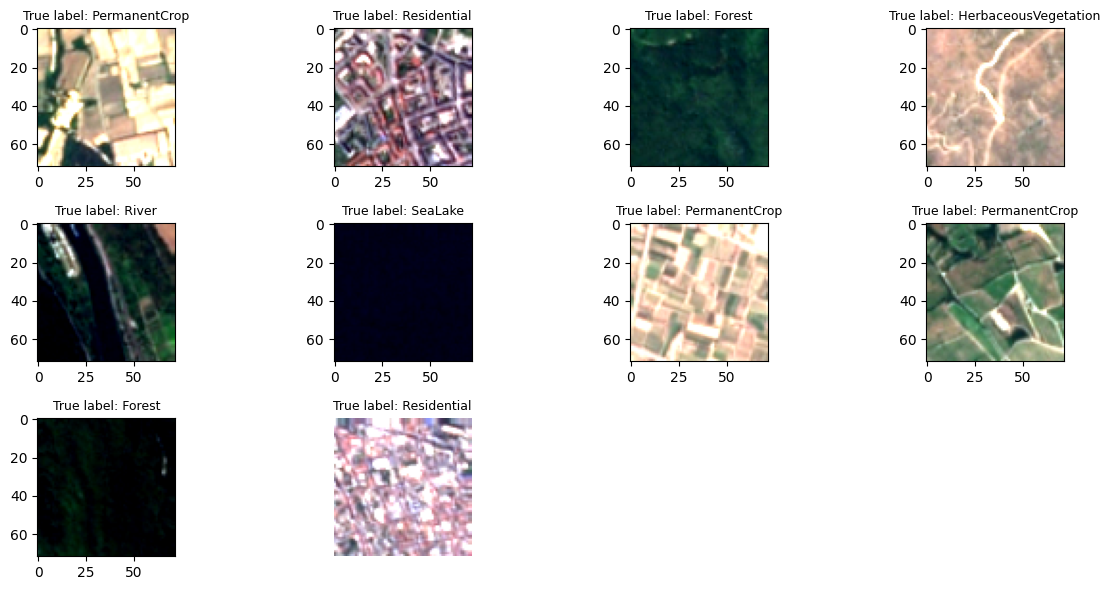

In [56]:
# load EuroSAT dataset
train_loader, valid_loader, test_loader, classes = get_EuroSAT_train_valid_loader(data_dir = './data',batch_size = 128, percent_train=0.8)

# Get a batch of images
examples = iter(train_loader)
images, labels = next(examples)
num_classes=len(classes)

print(f"Image batch shape: {images.shape}, Number of classes: {num_classes}")
plot_images(images, labels, classes, num_images=10)

100%|██████████| 7200/7200 [00:00<00:00, 1691725.33it/s]
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.72755873..2.3450103].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.6871302..2.318058].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.72755873..2.2253563].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.6871302..2.304582].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.90274906..2.2681682].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.79493964..2.057943].
Clipping input data to the valid range for imshow with RGB data ([0..1] 

Image batch shape: torch.Size([128, 3, 72, 72]), Number of classes: 100


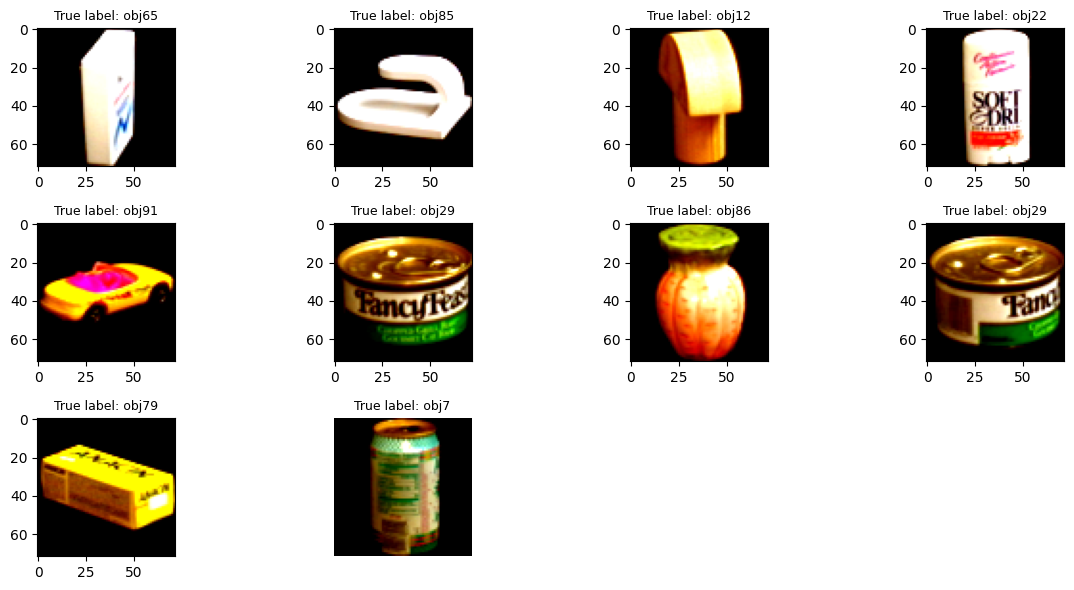

In [57]:

# load Coil-100 dataset
train_loader, valid_loader, test_loader, classes = get_coil100_train_valid_loader(batch_size = 128, percent_train=0.8)

# Get a batch of images
examples = iter(train_loader)
images, labels = next(examples)
num_classes=len(classes)

print(f"Image batch shape: {images.shape}, Number of classes: {num_classes}")
plot_images(images, labels, classes, num_images=10)


# start the training & evaluation of the model and then final test the model to predict the classes

Epoch 1/10 - Train Loss: 3.5902 - Val Loss: 1.4556 - Val Acc: 68.52%
Epoch 2/10 - Train Loss: 1.7396 - Val Loss: 0.5479 - Val Acc: 90.74%
Epoch 3/10 - Train Loss: 1.0394 - Val Loss: 0.1824 - Val Acc: 96.30%
Epoch 4/10 - Train Loss: 0.8322 - Val Loss: 0.1220 - Val Acc: 98.61%
Epoch 5/10 - Train Loss: 0.6988 - Val Loss: 0.0845 - Val Acc: 98.80%
Epoch 6/10 - Train Loss: 0.5851 - Val Loss: 0.0638 - Val Acc: 98.98%
Epoch 7/10 - Train Loss: 0.5137 - Val Loss: 0.0470 - Val Acc: 98.98%
Epoch 8/10 - Train Loss: 0.4517 - Val Loss: 0.0317 - Val Acc: 99.72%
Epoch 9/10 - Train Loss: 0.4365 - Val Loss: 0.0299 - Val Acc: 99.26%
Epoch 10/10 - Train Loss: 0.4002 - Val Loss: 0.0250 - Val Acc: 99.54%


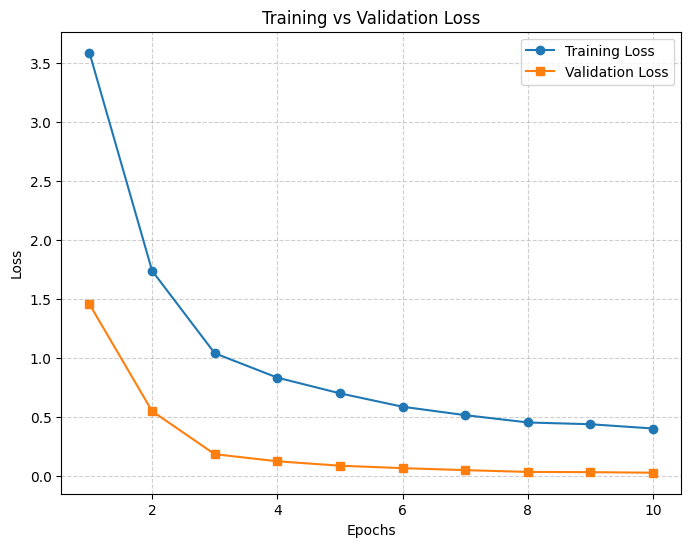

Test Accuracy: 100.00%


In [58]:
model = BaseCNN(num_classes).to(device)

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# --- Run training ---
train(model, train_loader, valid_loader, num_epochs=10)

# --- Test accuracy ---
_,test_acc = evaluate(model, test_loader)
print(f"Test Accuracy: {test_acc:.2f}%")

ANN Coil-100 60 Epoch 

Epoch 1/60 - Train Loss: 4.5729 - Val Loss: 4.1635 - Val Acc: 7.22%
Epoch 2/60 - Train Loss: 4.0386 - Val Loss: 3.4659 - Val Acc: 20.46%
Epoch 3/60 - Train Loss: 3.5838 - Val Loss: 2.8496 - Val Acc: 33.33%
Epoch 4/60 - Train Loss: 3.2706 - Val Loss: 2.4800 - Val Acc: 38.24%
Epoch 5/60 - Train Loss: 3.0371 - Val Loss: 2.1160 - Val Acc: 47.13%
Epoch 6/60 - Train Loss: 2.8246 - Val Loss: 1.9233 - Val Acc: 53.70%
Epoch 7/60 - Train Loss: 2.6821 - Val Loss: 1.7631 - Val Acc: 58.06%
Epoch 8/60 - Train Loss: 2.5786 - Val Loss: 1.5827 - Val Acc: 62.13%
Epoch 9/60 - Train Loss: 2.3651 - Val Loss: 1.4808 - Val Acc: 65.19%
Epoch 10/60 - Train Loss: 2.3187 - Val Loss: 1.2662 - Val Acc: 68.61%
Epoch 11/60 - Train Loss: 2.1863 - Val Loss: 1.1985 - Val Acc: 74.35%
Epoch 12/60 - Train Loss: 2.1043 - Val Loss: 1.0797 - Val Acc: 74.81%
Epoch 13/60 - Train Loss: 1.9907 - Val Loss: 1.1220 - Val Acc: 76.02%
Epoch 14/60 - Train Loss: 2.0034 - Val Loss: 0.9316 - Val Acc: 79.63%
Epoch 15/60 - Train Loss: 1.8982 - Val Loss: 0.9050 - Val Acc: 80.09%
Epoch 16/60 - Train Loss: 1.8602 - Val Loss: 0.8674 - Val Acc: 82.04%
Epoch 17/60 - Train Loss: 1.8032 - Val Loss: 0.8361 - Val Acc: 81.94%
Epoch 18/60 - Train Loss: 1.7404 - Val Loss: 0.7783 - Val Acc: 84.07%
Epoch 19/60 - Train Loss: 1.7147 - Val Loss: 0.7587 - Val Acc: 83.61%
Epoch 20/60 - Train Loss: 1.6817 - Val Loss: 0.6971 - Val Acc: 84.81%
Epoch 21/60 - Train Loss: 1.5819 - Val Loss: 0.6653 - Val Acc: 86.85%
Epoch 22/60 - Train Loss: 1.5574 - Val Loss: 0.6412 - Val Acc: 86.57%
Epoch 23/60 - Train Loss: 1.5903 - Val Loss: 0.6200 - Val Acc: 88.15%
Epoch 24/60 - Train Loss: 1.5590 - Val Loss: 0.6377 - Val Acc: 86.11%
Epoch 25/60 - Train Loss: 1.5606 - Val Loss: 0.5989 - Val Acc: 88.15%
Epoch 26/60 - Train Loss: 1.5137 - Val Loss: 0.5999 - Val Acc: 88.06%
Epoch 27/60 - Train Loss: 1.4627 - Val Loss: 0.5767 - Val Acc: 88.70%
Epoch 28/60 - Train Loss: 1.4500 - Val Loss: 0.5733 - Val Acc: 88.98%
Epoch 29/60 - Train Loss: 1.4343 - Val Loss: 0.5684 - Val Acc: 88.43%
Epoch 30/60 - Train Loss: 1.4413 - Val Loss: 0.4970 - Val Acc: 90.93%
Epoch 31/60 - Train Loss: 1.4070 - Val Loss: 0.5008 - Val Acc: 90.83%
Epoch 32/60 - Train Loss: 1.3238 - Val Loss: 0.5048 - Val Acc: 91.20%
Epoch 33/60 - Train Loss: 1.3589 - Val Loss: 0.4654 - Val Acc: 91.30%
Epoch 34/60 - Train Loss: 1.3508 - Val Loss: 0.4860 - Val Acc: 91.11%
Epoch 35/60 - Train Loss: 1.3059 - Val Loss: 0.4595 - Val Acc: 90.74%
Epoch 36/60 - Train Loss: 1.2955 - Val Loss: 0.4121 - Val Acc: 92.50%
Epoch 37/60 - Train Loss: 1.3329 - Val Loss: 0.4449 - Val Acc: 90.19%
Epoch 38/60 - Train Loss: 1.2530 - Val Loss: 0.4482 - Val Acc: 91.67%
Epoch 39/60 - Train Loss: 1.2267 - Val Loss: 0.3907 - Val Acc: 92.69%
Epoch 40/60 - Train Loss: 1.2351 - Val Loss: 0.3955 - Val Acc: 92.87%
Epoch 41/60 - Train Loss: 1.2267 - Val Loss: 0.3761 - Val Acc: 94.07%
Epoch 42/60 - Train Loss: 1.2461 - Val Loss: 0.3949 - Val Acc: 92.59%
Epoch 43/60 - Train Loss: 1.2298 - Val Loss: 0.3677 - Val Acc: 93.15%
Epoch 44/60 - Train Loss: 1.1816 - Val Loss: 0.3531 - Val Acc: 92.78%
Epoch 45/60 - Train Loss: 1.1820 - Val Loss: 0.3699 - Val Acc: 91.67%
Epoch 46/60 - Train Loss: 1.1445 - Val Loss: 0.3516 - Val Acc: 92.50%
Epoch 47/60 - Train Loss: 1.1467 - Val Loss: 0.3719 - Val Acc: 92.69%
Epoch 48/60 - Train Loss: 1.0811 - Val Loss: 0.2901 - Val Acc: 93.52%
Epoch 49/60 - Train Loss: 1.1141 - Val Loss: 0.3344 - Val Acc: 93.61%
Epoch 50/60 - Train Loss: 1.1065 - Val Loss: 0.3185 - Val Acc: 94.81%
Epoch 51/60 - Train Loss: 1.1063 - Val Loss: 0.3064 - Val Acc: 92.50%
Epoch 52/60 - Train Loss: 1.1211 - Val Loss: 0.3259 - Val Acc: 93.98%
Epoch 53/60 - Train Loss: 1.0843 - Val Loss: 0.3313 - Val Acc: 93.89%
Epoch 54/60 - Train Loss: 1.0914 - Val Loss: 0.2960 - Val Acc: 93.33%
Epoch 55/60 - Train Loss: 1.0564 - Val Loss: 0.3026 - Val Acc: 95.19%
Epoch 56/60 - Train Loss: 1.0667 - Val Loss: 0.2963 - Val Acc: 94.17%
Epoch 57/60 - Train Loss: 1.0482 - Val Loss: 0.2934 - Val Acc: 95.19%
Epoch 58/60 - Train Loss: 1.0320 - Val Loss: 0.2868 - Val Acc: 93.61%
Epoch 59/60 - Train Loss: 1.0197 - Val Loss: 0.3076 - Val Acc: 93.98%
Epoch 60/60 - Train Loss: 1.0888 - Val Loss: 0.3028 - Val Acc: 92.78%


Test Accuracy: 93.89%

## normal architecture

Epoch 1/20 - Train Loss: 1.6425 - Val Loss: 1.0709 - Val Acc: 65.75%
Epoch 2/20 - Train Loss: 1.2790 - Val Loss: 0.9349 - Val Acc: 69.36%
Epoch 3/20 - Train Loss: 1.1674 - Val Loss: 0.8215 - Val Acc: 73.06%
Epoch 4/20 - Train Loss: 1.1045 - Val Loss: 0.7655 - Val Acc: 73.90%
Epoch 5/20 - Train Loss: 1.0505 - Val Loss: 0.7220 - Val Acc: 75.21%
Epoch 6/20 - Train Loss: 1.0130 - Val Loss: 0.7275 - Val Acc: 73.65%
Epoch 7/20 - Train Loss: 0.9956 - Val Loss: 0.6821 - Val Acc: 76.42%
Epoch 8/20 - Train Loss: 0.9727 - Val Loss: 0.7768 - Val Acc: 72.07%
Epoch 9/20 - Train Loss: 0.9430 - Val Loss: 0.6163 - Val Acc: 78.77%
Epoch 10/20 - Train Loss: 0.9350 - Val Loss: 0.6576 - Val Acc: 76.84%
Epoch 11/20 - Train Loss: 0.8937 - Val Loss: 0.5951 - Val Acc: 79.38%
Epoch 12/20 - Train Loss: 0.8897 - Val Loss: 0.5583 - Val Acc: 80.84%
Epoch 13/20 - Train Loss: 0.8672 - Val Loss: 0.5509 - Val Acc: 79.98%
Epoch 14/20 - Train Loss: 0.8573 - Val Loss: 0.5423 - Val Acc: 81.04%
Epoch 15/20 - Train Loss: 0.8451 - Val Loss: 0.5708 - Val Acc: 79.88%
Epoch 16/20 - Train Loss: 0.8502 - Val Loss: 0.5255 - Val Acc: 81.98%
Epoch 17/20 - Train Loss: 0.8210 - Val Loss: 0.5097 - Val Acc: 83.31%
Epoch 18/20 - Train Loss: 0.8082 - Val Loss: 0.5220 - Val Acc: 82.27%
Epoch 19/20 - Train Loss: 0.7910 - Val Loss: 0.5099 - Val Acc: 81.85%
Epoch 20/20 - Train Loss: 0.7903 - Val Loss: 0.5210 - Val Acc: 82.47%

Test Accuracy: 82.59%

# No Dropout Layers

Epoch 1/20 - Train Loss: 1.4225 - Val Loss: 0.8233 - Val Acc: 71.11%
Epoch 2/20 - Train Loss: 0.7364 - Val Loss: 0.7211 - Val Acc: 74.44%
Epoch 3/20 - Train Loss: 0.6307 - Val Loss: 0.5788 - Val Acc: 79.21%
Epoch 4/20 - Train Loss: 0.5527 - Val Loss: 0.7000 - Val Acc: 75.21%
Epoch 5/20 - Train Loss: 0.4878 - Val Loss: 0.5249 - Val Acc: 81.85%
Epoch 6/20 - Train Loss: 0.4484 - Val Loss: 0.5122 - Val Acc: 81.85%
Epoch 7/20 - Train Loss: 0.4358 - Val Loss: 0.5440 - Val Acc: 81.23%
Epoch 8/20 - Train Loss: 0.3724 - Val Loss: 0.4103 - Val Acc: 86.07%
Epoch 9/20 - Train Loss: 0.3500 - Val Loss: 0.4395 - Val Acc: 84.91%
Epoch 10/20 - Train Loss: 0.3135 - Val Loss: 0.3964 - Val Acc: 86.35%
Epoch 11/20 - Train Loss: 0.3243 - Val Loss: 0.4172 - Val Acc: 86.37%
Epoch 12/20 - Train Loss: 0.2914 - Val Loss: 0.4916 - Val Acc: 84.54%
Epoch 13/20 - Train Loss: 0.2893 - Val Loss: 0.4431 - Val Acc: 84.79%
Epoch 14/20 - Train Loss: 0.2354 - Val Loss: 0.3810 - Val Acc: 87.65%
Epoch 15/20 - Train Loss: 0.2656 - Val Loss: 0.4047 - Val Acc: 86.89%
Epoch 16/20 - Train Loss: 0.2041 - Val Loss: 0.4353 - Val Acc: 85.90%
Epoch 17/20 - Train Loss: 0.2025 - Val Loss: 0.3720 - Val Acc: 88.44%
Epoch 18/20 - Train Loss: 0.2132 - Val Loss: 0.3738 - Val Acc: 88.27%
Epoch 19/20 - Train Loss: 0.1842 - Val Loss: 0.3819 - Val Acc: 87.80%
Epoch 20/20 - Train Loss: 0.1637 - Val Loss: 0.4546 - Val Acc: 86.77%

Test Accuracy: 85.93%

## No Batchnorm architecture

Epoch 1/20 - Train Loss: 1.2370 - Val Loss: 0.8429 - Val Acc: 69.04%
Epoch 2/20 - Train Loss: 0.8089 - Val Loss: 0.6705 - Val Acc: 77.19%
Epoch 3/20 - Train Loss: 0.6828 - Val Loss: 0.5508 - Val Acc: 81.16%
Epoch 4/20 - Train Loss: 0.6218 - Val Loss: 0.5002 - Val Acc: 83.16%
Epoch 5/20 - Train Loss: 0.5521 - Val Loss: 0.4731 - Val Acc: 84.20%
Epoch 6/20 - Train Loss: 0.5014 - Val Loss: 0.4432 - Val Acc: 85.06%
Epoch 7/20 - Train Loss: 0.4741 - Val Loss: 0.4269 - Val Acc: 85.85%
Epoch 8/20 - Train Loss: 0.4376 - Val Loss: 0.4056 - Val Acc: 86.42%
Epoch 9/20 - Train Loss: 0.4000 - Val Loss: 0.3956 - Val Acc: 86.99%
Epoch 10/20 - Train Loss: 0.3792 - Val Loss: 0.3799 - Val Acc: 87.43%
Epoch 11/20 - Train Loss: 0.3438 - Val Loss: 0.3729 - Val Acc: 87.75%
Epoch 12/20 - Train Loss: 0.3259 - Val Loss: 0.3705 - Val Acc: 87.83%
Epoch 13/20 - Train Loss: 0.3114 - Val Loss: 0.3424 - Val Acc: 88.94%
Epoch 14/20 - Train Loss: 0.2914 - Val Loss: 0.3387 - Val Acc: 88.74%
Epoch 15/20 - Train Loss: 0.2822 - Val Loss: 0.3716 - Val Acc: 88.12%
Epoch 16/20 - Train Loss: 0.2705 - Val Loss: 0.3335 - Val Acc: 89.06%
Epoch 17/20 - Train Loss: 0.2460 - Val Loss: 0.3256 - Val Acc: 89.56%
Epoch 18/20 - Train Loss: 0.2466 - Val Loss: 0.3802 - Val Acc: 88.77%
Epoch 19/20 - Train Loss: 0.2309 - Val Loss: 0.3808 - Val Acc: 88.37%
Epoch 20/20 - Train Loss: 0.2214 - Val Loss: 0.3914 - Val Acc: 88.84%


Test Accuracy: 89.85%


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.70060635..2.1334062].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.79493964..2.4123914].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.6871302..2.0755148].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.6871302..2.1932476].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.86232054..2.439344].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.6871302..2.3315344].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.6736

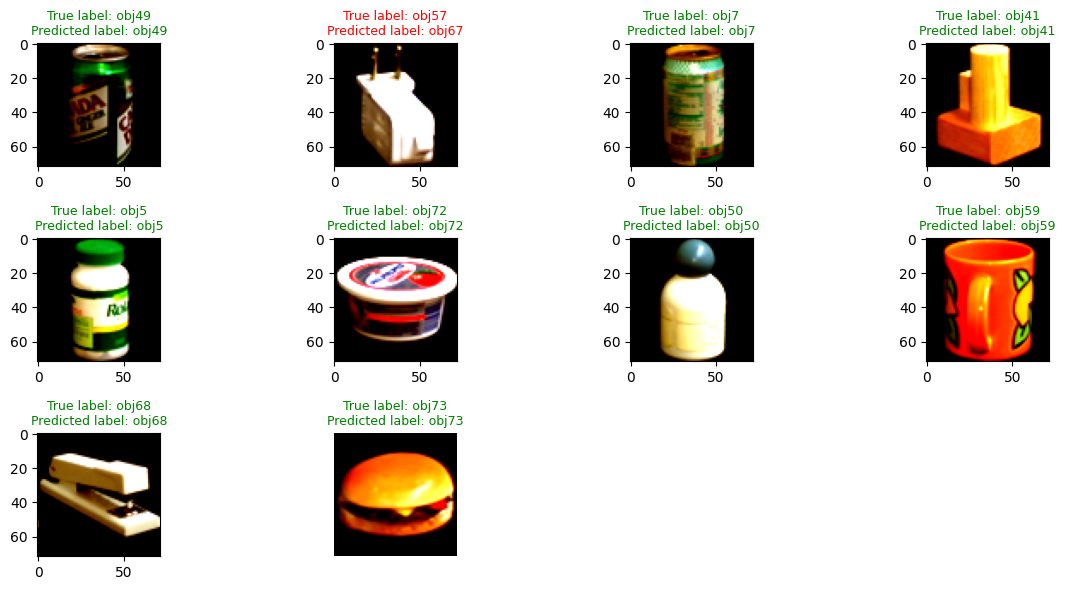

In [61]:

images, labels = next(iter(test_loader))
images, labels = images.to(device), labels.to(device)

model = model.to(device)

outputs = model(images)
_, preds = torch.max(outputs, 1)

plot_images(images.cpu(), labels.cpu().tolist(), classes, preds=preds.cpu().tolist(), num_images=10)


In [60]:

summary(model, input_size=(1, 3, 72, 72))


Layer (type:depth-idx)                   Output Shape              Param #
BaseCNN                                  [1, 100]                  --
├─Conv2d: 1-1                            [1, 32, 72, 72]           896
├─BatchNorm2d: 1-2                       [1, 32, 72, 72]           64
├─ReLU: 1-3                              [1, 32, 72, 72]           --
├─MaxPool2d: 1-4                         [1, 32, 36, 36]           --
├─Conv2d: 1-5                            [1, 64, 36, 36]           18,496
├─BatchNorm2d: 1-6                       [1, 64, 36, 36]           128
├─ReLU: 1-7                              [1, 64, 36, 36]           --
├─MaxPool2d: 1-8                         [1, 64, 18, 18]           --
├─Dropout: 1-9                           [1, 64, 18, 18]           --
├─Flatten: 1-10                          [1, 20736]                --
├─Linear: 1-11                           [1, 128]                  2,654,336
├─Dropout: 1-12                          [1, 128]                  --
├─

# Architecture when Pooling is removed

### Loading the Dataset EuroSAT dataset

# Provide your answers to Experiment and Reflection

### - What choices affect the model's accuracy?
There are many choices that affect the accuracy.
Some of the most important include:

- Model architecture:  The number of layers,type of layers and how they are connected all have a big impact on how well the model learns and the accuracy.
- Hyperparameters: Learning rate,batch size, number of epoch, can strongly affect convergence and generalization.
- Regularization technique: Using methods like dropout, batch normalization helps prevent overfittingan and improves accuracy.
- Data quantity: More training data helps the accuracy for the model and improves the performence.
- Preprocessing: Correct done normalization , good choice of data augmentationcan also improve the accuracy and generalization of the model.
- Activation function: The choice of activation function can also influences the model and its accuracy to learn complex patterns.  

### - How do you determine whether the model is  overfitting or underfitting?

A model is overfitting when the training loss continues to decrease while the validation loss stops improving  or starts increasing after few epochs.
The model is memorizing the training data instead of learning the patterns, leading to poor generalization on unseen data. The gap between training and validation loss becomes larger also.

A model is underfitting when both training and validation loss remain high and show little improvments over time. This normaly is a indication that the model
is a bit simple and need more layers to capture the pattern and strucuture of the data.

### - What happens when you add or remove components, for example, dropout or batch normalization?

When the droput layer is removed, the model tends to overfit very quickly. The validation loss starts oscillating and remains above the training loss.
Without droput, all neurons are activated during training, which makes the model learn faster but also memorize the training data instead of generalizing.

When the batch normalization layer is removed, the model also begins to overfit,through usally more gradually compared to removing droput. Batch normalization helps stabilize the learning process. Without it, training become less stable.


### - What layer causes the highest number of parameters?
 The first fully connected linear layer contains the highest numbers of parameters 2,654,336.
 This happends becuase it connects all the flattened features from the convolution layers  
 64 * 18 * 18 = 20736 to 128 neurons + 128 bias.

### - what happens if you remove all pooling layers in a CNN?
If all pooling layers are removed, the feature maps do not shrink in size. This means the final output from the convolutional layers remains much larger, for example 64 * 72 * 72 = 331776 features instead of 64 * 18 * 18 = 20736

Becuase of this, the flattened features becomes too large, and the input size no longer matches what the first fully connected layer expect. This mismatch causes a runtime error. If the model would manage to run, it would require far more memory and parameters, leading to slower training and higher overfitting risk.


### - In a CNN block, can you arrange the layer (i.e. Conv, ReLU, BatchNorm, Dropout) in any order? Explain your answer.

While it´s possible to rearrange layers like BatchNorm and Dropout, or even removing them, doing so changes how the model learns, and caused overfitting and unstable trainig.

For example, placing BatchNorm after Relu is not ideal, since ReLu clips negative values to zero,meaning BatchNorm can no longer normalize the full range of activations. This lead to worse performence and a higher risk of overfitting. When placed before ReLU,batchNorm keeps gradients well-scaled and helps the netwrok train smoothly.

Similary placing Dropout before RelU harmed learning and overfitted, since the activations then operates mostly on zeros, reducing useful information.

Placering RelU at diffrent location for example direct after first convulution layer shows sign of overfitting at later epoch, but still possible to train model.
If layers like Conv are moved incorrectly for example after BatchNorm expecting a input of 3 channels instead of 32, it caused a runtime error due to channel mismatch.